In [1]:
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def transform_to_csv_with_timestamps(input_file, output_file):
    data = []
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    current_word = None
    time = 0
    delta = 1/60
    word_id = 1
    
    for line in lines:
        line = line.strip()
        if line:
            if current_word is None:
                current_word = line
            else:
                x, y = line.split(',')
                data.append([word_id, current_word, time, x, y])
                time += delta
        else:
            current_word = None
            time = 0  # Reset time to continue the next word's time sequence
            word_id += 1

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['word_id', 'word', 'time', 'x', 'y'])
    
    # Save to CSV
    df.to_csv(output_file, index=False)

In [3]:
# Use the function
input_file = '../data/gaze-collection1.txt'  # Replace with your input file name
output_file = '../data/collection_v1.csv'  # Replace with your desired output file name
transform_to_csv_with_timestamps(input_file, output_file)

input_file = '../data/gaze-collection2.txt'  # Replace with your input file name
output_file = '../data/collection_v2.csv'  # Replace with your desired output file name
transform_to_csv_with_timestamps(input_file, output_file)


ValueError: too many values to unpack (expected 2)

# **Clustering**

In [2]:
df_words = pd.read_csv('../data/collection_v1.csv')

In [3]:
df_words.head()

,word_id,word,time,x,y
0,1,CAPABLE,0.000000,0.066968,-0.104396
1,1,CAPABLE,0.016667,0.066968,-0.104396
2,1,CAPABLE,0.033333,0.118470,-0.110243
3,1,CAPABLE,0.050000,0.100974,-0.106546
4,1,CAPABLE,0.066667,0.086544,-0.110963


Now, let's group by word_id and separate into smaller dataframes

In [4]:
df_words_grouped = df_words.groupby('word_id')

Let's take the first word to make some tests

In [5]:
first_word = df_words_grouped.get_group(5)

print(first_word.shape)
first_word.head()

(352, 5)


,word_id,word,time,x,y
1357,5,PROCESS,0.000000,0.035358,-0.062175
1358,5,PROCESS,0.016667,0.064725,-0.047400
1359,5,PROCESS,0.033333,0.025906,-0.056816
1360,5,PROCESS,0.050000,0.039063,-0.049353
1361,5,PROCESS,0.066667,0.017513,-0.053382


In [6]:
# Filter out all points where the y is less than -0.01

first_word = first_word[first_word['y'] > 0]

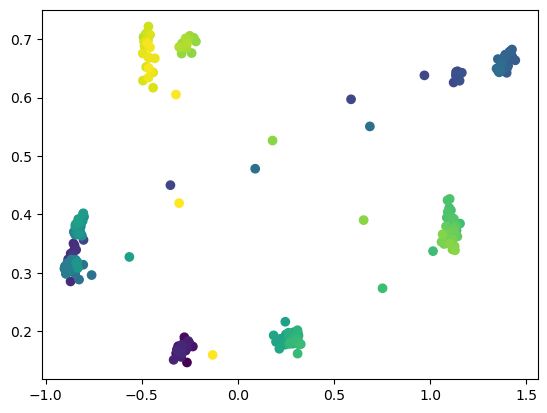

In [7]:
# Plot the points x, y for the first word, time should be the color

plt.scatter(first_word['x'], first_word['y'], c=first_word.index, cmap='viridis')

In [8]:
def cluster_fixations_3d(df, eps=0.1, min_samples=5):
    # Extract relevant columns for clustering (x, y, time)
    df['time'] = df['time'].astype(float)
    X = df[['x', 'y', 'time']].astype(float)
    
    # Apply DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    df['cluster'] = db.labels_

    print(f"Number of clusters: {len(set(db.labels_))}")

    return df, db

In [9]:
df_cluster, db = cluster_fixations_3d(first_word, eps=0.1, min_samples=5)

Number of clusters: 10


In [21]:
def visualize_3d_clusters(df, db):
    X = df[['x', 'y', 'time']].astype(float)
    
    # Plot the clusters in 3D
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = set(db.labels_)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (db.labels_ == k)
        
        xyz = X[class_member_mask]
        ax.scatter(xyz['x'], xyz['y'], xyz['time'], c=[tuple(col)], marker='o', s=50, edgecolors='k')
    
    ax.set_title('Clustering of Eye Tracking Data')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Time (s)')
    plt.savefig('3d_clusters.png')
    plt.show()

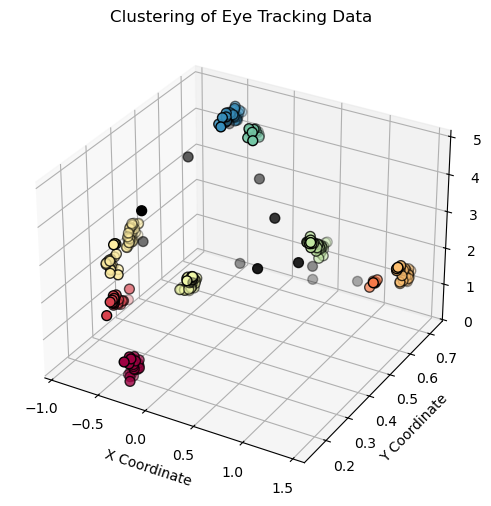

In [22]:
visualize_3d_clusters(df_cluster, db)

In [30]:
# Print the centroids of the clusters and how many points are in each cluster

def print_cluster_centroids(df):
    centroids = df.groupby('cluster')[['x', 'y', 'time']].mean()
    counts = df['cluster'].value_counts()
    
    for cluster_id, centroid in centroids.iterrows():
        count = counts[cluster_id]
        print(f"Cluster {cluster_id}: {centroid.values} (n={count})")

In [31]:
print_cluster_centroids(df_cluster)

Cluster -1: [0.25144727 0.4424406  3.06410256] (n=13)
Cluster 0: [-0.28644144  0.1698604   0.54462366] (n=31)
Cluster 1: [-0.86190512  0.32397586  1.01666667] (n=25)
Cluster 2: [1.1436973  0.63854887 1.35833333] (n=10)
Cluster 3: [1.39373148 0.6617308  1.68333333] (n=29)
Cluster 4: [-0.84003703  0.35056147  2.4       ] (n=53)
Cluster 5: [0.27724114 0.18616721 3.125     ] (n=32)
Cluster 6: [1.10963836 0.37452793 3.725     ] (n=36)
Cluster 7: [-0.26718924  0.69217115  4.18333333] (n=15)
Cluster 8: [-0.46989241  0.68117053  4.55      ] (n=29)


In [32]:
# Filter out clusters with less than 10 points

def filter_clusters(df, min_points=10):
    counts = df['cluster'].value_counts()
    valid_clusters = counts[counts >= min_points].index
    df_filtered = df[df['cluster'].isin(valid_clusters)]

    # Filter out cluster -1 (noise)
    df_filtered = df_filtered[df_filtered['cluster'] != -1]
    
    return df_filtered

In [33]:
df_cluster = filter_clusters(df_cluster, min_points=20)

In [34]:
def create_keyboard(path: str, KEY_LENGTH=.2) -> dict:
    with open(path, 'r') as f:
        lines = f.readlines()
    
    keyboard = {}
    for line in lines:
        key, center = line.strip().split()

        center = center.replace('(', '').replace(')', '')

        center_x, center_y = center.split(',')
        center_x, center_y = float(center_x), float(center_y)

        keyboard[key] = (
            (center_x, center_y), # Center (x, y)
            (center_x - KEY_LENGTH/2, center_y + KEY_LENGTH/2), # Top left
            (center_x + KEY_LENGTH/2, center_y + KEY_LENGTH/2), # Top right
            (center_x + KEY_LENGTH/2, center_y - KEY_LENGTH/2), # Bottom right
            (center_x - KEY_LENGTH/2, center_y - KEY_LENGTH/2)  # Bottom left
        )
    
    return keyboard

In [35]:
kb = create_keyboard('../data/keyboard2.txt')

Now, we are going to find, for each centroid, the closest center of key in the keyboard

In [38]:
def find_key_centroid(df_cluster, keyboard):
    centroids = df_cluster.groupby('cluster')[['x', 'y']].mean()

    keys = []
    
    for cluster_id, centroid in centroids.iterrows():
        distances = {}
        for key, points in keyboard.items():
            center, top_left, top_right, bottom_right, bottom_left = points
            distance = np.linalg.norm(np.array(centroid) - np.array(center))
            distances[key] = distance
        
        # Print 3 smallest distances
        sorted_distances = sorted(distances.items(), key=lambda x: x[1])

        keys.append(sorted_distances[:3])

        print(f"Cluster {cluster_id}: " + ', '.join([f"{key} ({distance:.2f})" for key, distance in sorted_distances[:3]]))
    
    return keys

In [19]:
find_key_centroid(df_cluster, kb)

Cluster 0: C (0.03), X (0.25), D (0.31)
Cluster 1: Z (0.14), A (0.15), S (0.27)
Cluster 3: P (0.15), O (0.18), L (0.20)
Cluster 4: A (0.14), Z (0.16), S (0.24)
Cluster 5: B (0.02), V (0.26), G (0.29)
Cluster 6: K (0.11), L (0.24), M (0.31)
Cluster 8: E (0.08), D (0.24), W (0.26)


## Testing for all groups

In [20]:
# hide pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Let's test for all groups now

for word_id, group in df_words_grouped:
    print(f"Word {word_id}")
    group = group[group['y'] > 0]
    group, db = cluster_fixations_3d(group, eps=0.1, min_samples=5)
    group = filter_clusters(group, min_points=20)
    find_key_centroid(group, kb)
    print()

Word 1
Number of clusters: 6
Cluster 0: J (0.12), H (0.21), N (0.22)
Cluster 1: I (0.16), K (0.18), O (0.19)
Cluster 2: H (0.11), G (0.18), Y (0.25)
Cluster 3: N (0.08), B (0.21), H (0.25)
Cluster 4: Y (0.10), T (0.20), G (0.26)

Word 2
Number of clusters: 9
Cluster 0: C (0.04), X (0.27), V (0.30)
Cluster 1: A (0.12), S (0.19), Z (0.22)
Cluster 2: B (0.07), V (0.22), G (0.30)
Cluster 3: A (0.11), Z (0.20), S (0.30)
Cluster 4: K (0.10), I (0.23), O (0.24)
Cluster 5: O (0.14), L (0.17), P (0.23)
Cluster 7: E (0.07), D (0.24), W (0.27)

Word 3
Number of clusters: 10
Cluster 0: C (0.07), V (0.28), X (0.30)
Cluster 1: A (0.17), Z (0.17), S (0.19)
Cluster 2: O (0.13), L (0.16), P (0.26)
Cluster 3: A (0.13), Z (0.16), S (0.28)
Cluster 4: B (0.14), V (0.17), G (0.35)
Cluster 6: K (0.13), L (0.19), M (0.36)
Cluster 8: E (0.06), W (0.25), D (0.26)

Word 4
Number of clusters: 13
Cluster 0: C (0.04), D (0.25), X (0.27)
Cluster 1: A (0.13), Z (0.17), S (0.24)
Cluster 3: O (0.13), P (0.19), L (0.20)

In [22]:
df_words_2 = pd.read_csv('../data/collection_v2.csv')

In [23]:
df_words_2_grouped = df_words_2.groupby('word_id')

df_words_2_grouped.get_group(20).head()

,word_id,word,time,x,y
5263,20,HISTORY,0.000000,0.178272,-0.113056
5264,20,HISTORY,0.016667,0.178248,-0.113103
5265,20,HISTORY,0.033333,0.178248,-0.113103
5266,20,HISTORY,0.050000,0.178248,-0.113103
5267,20,HISTORY,0.066667,0.178163,-0.113116


In [24]:
for word_id, group in df_words_2_grouped:
    try:
        print(f"Word {word_id}")
        group = group[group['y'] > 0]
        group, db = cluster_fixations_3d(group, eps=0.1, min_samples=5)
        group = filter_clusters(group, min_points=10)
        find_key_centroid(group, kb)
        print()
    except:
        print(f"Word {word_id} failed")
        print()

Word 1
Number of clusters: 6
Cluster 0: J (0.06), K (0.24), U (0.28)
Cluster 1: O (0.14), I (0.15), K (0.25)
Cluster 2: H (0.05), G (0.23), Y (0.26)
Cluster 3: N (0.13), B (0.18), H (0.35)
Cluster 4: Y (0.08), T (0.21), G (0.28)

Word 2
Number of clusters: 9
Cluster 0: G (0.05), B (0.24), H (0.28)
Cluster 1: R (0.09), E (0.21), D (0.25)
Cluster 2: E (0.06), W (0.23), S (0.28)
Cluster 3: A (0.01), S (0.28), Q (0.29)
Cluster 4: R (0.06), F (0.25), E (0.27)
Cluster 5: T (0.09), R (0.20), F (0.28)
Cluster 6: E (0.06), R (0.23), D (0.26)
Cluster 7: R (0.06), E (0.22), D (0.29)

Word 3
Number of clusters: 10
Cluster 0: G (0.07), F (0.21), T (0.26)
Cluster 1: R (0.08), E (0.25), F (0.25)
Cluster 2: E (0.05), W (0.24), D (0.28)
Cluster 3: A (0.01), S (0.27), Q (0.29)
Cluster 4: T (0.10), R (0.18), F (0.29)
Cluster 7: E (0.07), W (0.25), D (0.26)
Cluster 8: R (0.08), E (0.21), D (0.27)

Word 4
Number of clusters: 13
Cluster 1: G (0.08), F (0.25), B (0.25)
Cluster 3: E (0.11), R (0.19), D (0.23)

# **TRIE Testing**

In [40]:
import sys

sys.path.append('../')

from src.trie import create_trie, Node

trie = create_trie('../data/wordFrequency.xlsx')
kb = create_keyboard('../data/keyboard2.txt')

In [39]:
first_word = df_words_grouped.get_group(5)

first_word = first_word[first_word['y'] > 0]

group, db = cluster_fixations_3d(first_word, eps=0.1, min_samples=5)
group = filter_clusters(group, min_points=20)
keys = find_key_centroid(group, kb)

Number of clusters: 10
Cluster 0: C (0.03), X (0.25), D (0.31)
Cluster 1: Z (0.14), A (0.15), S (0.27)
Cluster 3: P (0.15), O (0.18), L (0.20)
Cluster 4: A (0.14), Z (0.16), S (0.24)
Cluster 5: B (0.02), V (0.26), G (0.29)
Cluster 6: K (0.11), L (0.24), M (0.31)
Cluster 8: E (0.08), D (0.24), W (0.26)


In [41]:
T = 1

def update_trie(hold_nodes: set, candidates: dict, trie: Node, key: str, score: float, time: float):
    # If the user is pointing to a key, get the initial node for that letter and put it in the hold set if it's not there
    key = key.lower()

    node = trie.child[ord(key) - ord('a')]

    # Update the node that starts new words
    if node is not None:
        hold_nodes.add(node)
    
    new_nodes = set()

    # Also, get all the hold nodes and see if their children are the character that the user is pointing to
    for node in hold_nodes:
        if node.child[ord(key) - ord('a')] is not None and node.child[ord(key) - ord('a')].letter not in hold_nodes:
            child = node.child[ord(key) - ord('a')]
            new_nodes.add(child)
            child.score = max(child.score, score)

            if child.word_end:
                for word in child.word:
                    if word not in candidates:
                        candidates[word] = (calculate_candidate_score(child), time)
    
    # Merge the hold nodes with the new nodes
    hold_nodes.update(new_nodes)

    update_candidates(candidates, time)


def calculate_candidate_score(node: Node) -> float:
    score = 0
    while node.parent is not None:
        score += node.score
        node = node.parent
    
    return score


def update_candidates(candidates: dict, time: float):
    # Remove the candidates that are there for more than T time
    for key in list(candidates.keys()):
        if time - candidates[key][1] > T:
            del candidates[key]


In [42]:
hold_nodes = set()
candidates = {}

for key in keys:
    for k in key:
        update_trie(hold_nodes, candidates, trie, k[0], 1/k[1], 0)

In [45]:
sorted(candidates.items(), key=lambda x: x[1][0], reverse=True)[:3]

[('capable', (np.float64(81.75850546154373), 0)),
 ('cable', (np.float64(68.04328828694803), 0)),
 ('able', (np.float64(60.8189520458127), 0))]

# **LLM Testing**

We are going to try to access an LLM get the top 3 suggestions of words that could have been typed by the user

In [79]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

genai.configure(api_key=os.environ.get("API_KEY"))

In [80]:
model = genai.GenerativeModel('gemini-1.5-flash')
chat = model.start_chat(history=[
    '''
    From now on, you are a linguistic specialist. Your biggest goal is to be able to discover the word that someone typed based on the possible letters that
    they could have been looking at. You have access to the coordinates of the center of the keys of the keyboard, and you will always receive the a list of the top 3
    keys for each cluster, which means each letter. Added to that, you will use your knowledge of the English language to help you to find real english words
    that are most probable to be typed. You can consider that there might be missing a letter, or that there might be extra letters.

    Your input will be the list of the top 3 keys for each cluster and their distances to the centroid, and you should return the TOP 3 most probable words that could
    have been typed. Your output should ONLY contain the words, separated by commas. Nothing more.

    Example:
    Cluster 0: C (0.03), X (0.25), D (0.31)
    Cluster 1: Z (0.14), A (0.15), S (0.27)
    Cluster 3: P (0.15), O (0.18), L (0.20)
    Cluster 4: A (0.14), Z (0.16), S (0.24)
    Cluster 5: B (0.02), V (0.26), G (0.29)
    Cluster 6: K (0.11), L (0.24), M (0.31)
    Cluster 8: E (0.08), D (0.24), W (0.26)

    Real Word: CAPABLE
    ''',
    f'''
    Keyboard coordinates:
    {kb}
    '''
])

In [102]:
first_word = df_words_2_grouped.get_group(7)
first_word = first_word[first_word['y'] > 0]
first_word, db = cluster_fixations_3d(first_word, eps=0.1, min_samples=5)
first_word = filter_clusters(first_word, min_points=20)
keys = find_key_centroid(first_word, kb)

response = model.generate_content(
    [
    '''
    From now on, you are a linguistic specialist. Your biggest goal is to be able to discover the word that someone typed based on the possible letters that
    they could have been looking at. You have access to the coordinates of the center of the keys of the keyboard, and you will always receive the a list of the top 3
    keys for each cluster, which means each letter. Added to that, you will use your knowledge of the English language to help you to find real english words
    that are most probable to be typed. You can consider that there might be missing a letter, or that there might be extra letters.

    Your input will be the list of the top 3 keys for each cluster and their distances to the centroid, and you should return the TOP 3 most probable words that could
    have been typed. Your output should ONLY contain the words, separated by commas. Nothing more.

    There could be names and proper nouns! Removing characters should have a bigger cost than substituting characters. And doubled letters are only typed once! Example:
    NN -> N

    Steps:
    1. Prioritize the closest letters from each cluster.
    2. Consider the keys that are closer to the cluster. For instance, if the cluster is closer to J, H and N, you should not consider Q for the position
    3. Check for common English word patterns.
    4. Select words that might be valid based on familiarity with English vocabulary.

    Example:
    Cluster 0: C (0.03), X (0.25), D (0.31)
    Cluster 1: Z (0.14), A (0.15), S (0.27)
    Cluster 3: P (0.15), O (0.18), L (0.20)
    Cluster 4: A (0.14), Z (0.16), S (0.24)
    Cluster 5: B (0.02), V (0.26), G (0.29)
    Cluster 6: K (0.11), L (0.24), M (0.31)
    Cluster 8: E (0.08), D (0.24), W (0.26)

    Real Word: CAPABLE
    ''',
    f'''
    Keyboard coordinates:
    {kb}
    ''',
    f"{keys}"
]
)

response.text

Number of clusters: 9
Cluster 0: A (0.09), S (0.19), Z (0.26)
Cluster 1: N (0.05), B (0.23), H (0.28)
Cluster 2: O (0.13), I (0.16), K (0.26)
Cluster 4: T (0.07), R (0.21), F (0.28)
Cluster 5: H (0.12), G (0.16), Y (0.27)
Cluster 6: E (0.09), D (0.20), R (0.27)
Cluster 7: R (0.05), F (0.26), E (0.26)


'NORTH, NORT, NORTHS \n'